In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 25s 324ms/step - loss: 0.2103 - root_mean_squared_error: 0.4586 - val_loss: 0.1534 - val_root_mean_squared_error: 0.3916
Epoch 2/50
53/53 [==============================] - 16s 315ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617 - val_loss: 0.0692 - val_root_mean_squared_error: 0.2630
Epoch 3/50
53/53 [==============================] - 16s 313ms/step - loss: 0.0502 - root_mean_squared_error: 0.2240 - val_loss: 0.0637 - val_root_mean_squared_error: 0.2524
Epoch 4/50
53/53 [==============================] - 18s 345ms/step - loss: 0.0472 - root_mean_squared_error: 0.2173 - val_loss: 0.0604 - val_root_mean_squared_error: 0.2457
Epoch 5/50
53/53 [==============================] - 17s 327ms/step - loss: 0.0423 - root_mean_squared_error: 0.2057 - val_loss: 0.0557 - val_root_mean_squared_error: 0.2360
Epoch 6/50
53/53 [==============================] - 18s 335ms/step - loss: 0.0368 - root_mean_squared_error: 0.1919 - val_loss: 0.0427 

Epoch 28/50
53/53 [==============================] - 2s 46ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1181
Epoch 29/50
53/53 [==============================] - 3s 51ms/step - loss: 0.0082 - root_mean_squared_error: 0.0908 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 30/50
53/53 [==============================] - 19s 357ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 31/50
53/53 [==============================] - 20s 389ms/step - loss: 0.0083 - root_mean_squared_error: 0.0909 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 32/50
53/53 [==============================] - 20s 383ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 33/50
53/53 [==============================] - 19s 361ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.013

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

14.040588768323262 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

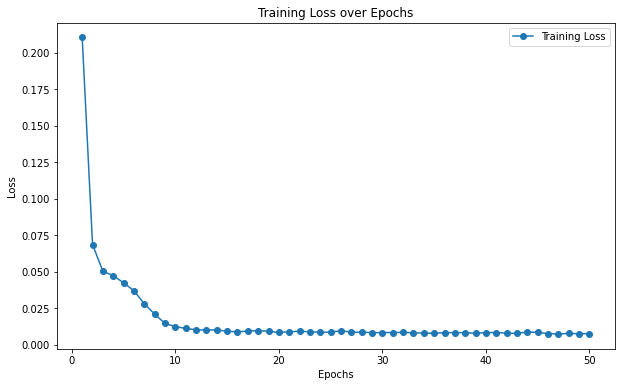

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

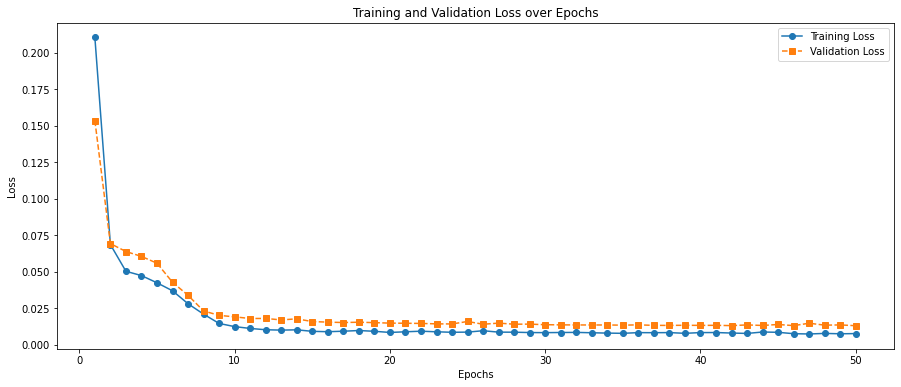

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 18ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.09152162197661343
MAE : 0.0723305969243917


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.201218e+06,1914289.680
1,1.857237e+06,1802244.842
2,1.324804e+06,1202791.069
3,8.267311e+05,752834.272
4,4.535940e+05,451914.219
5,4.338992e+05,439855.813
6,6.832664e+05,807857.307
7,1.088959e+06,1184280.145
8,1.513350e+06,1468308.405
9,1.837684e+06,1540851.607


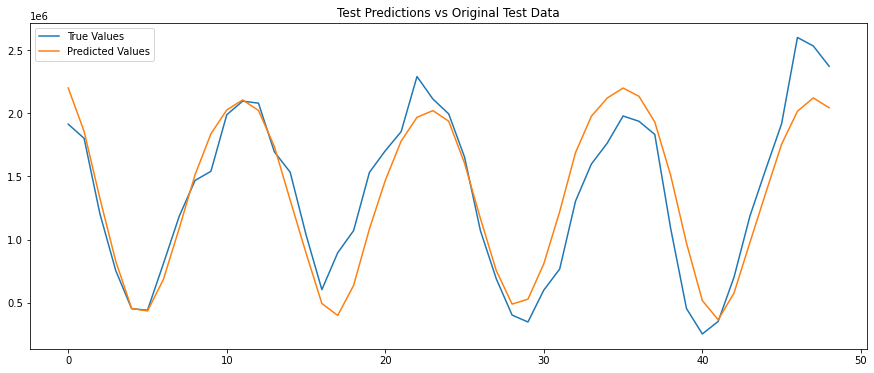

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 21ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

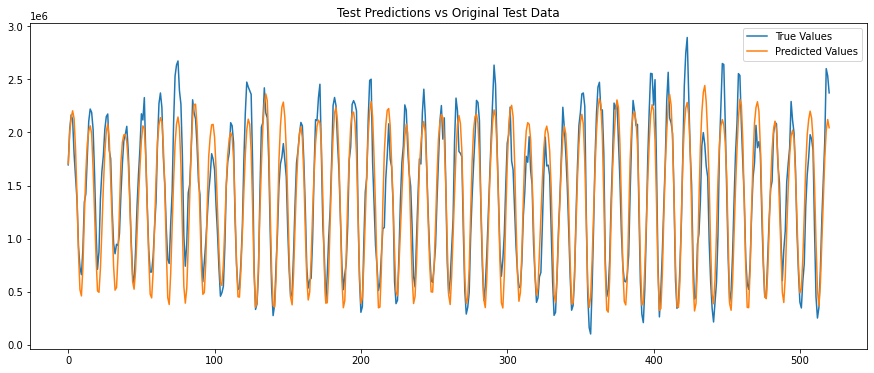

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()